In [67]:
import sklearn
import pickle
from pathlib import Path
from collections import defaultdict
from tqdm.notebook import tqdm
import numpy as np

In [68]:
repr_dir = Path('F:/datasets/PRV_KEMI_DATA/patent_sbert_no_overlap')

patent_sbert_paths = [
{'label': 0, 'path': repr_dir / 'patent_sbert_no_images_english_netto_list.pkl'},
{'label': 1, 'path': repr_dir / 'patent_sbert_no_images_complement_english.pkl'},
{'label': 2, 'path': repr_dir / 'patent_sbert_no_images_english_random_sample.pkl'},
]


In [69]:
with open(patent_sbert_paths[0]['path'], 'rb') as fp:
    repr = pickle.load(fp)

In [6]:
repr[0]['vectors'].keys()

dict_keys(['abstract_vector', 'description_vector', 'claims_vector'])

In [70]:
def stack_representations(representation_path, taken_numbers):
    with open(representation_path, 'rb') as fp:
        representations = pickle.load(fp)

    patent_numbers = []
    vectors = defaultdict(list)
    for doc_repr in tqdm(representations):
        patent_number = doc_repr['patent_number']
        if patent_number in taken_numbers:
            continue
        patent_numbers.append(patent_number)
        taken_numbers.add(patent_number)
        for vec_name, vec_value in doc_repr['vectors'].items():
            vectors[vec_name].append(vec_value)
    vectors = {vec_name: np.stack(vec_list) for vec_name, vec_list in vectors.items()}
    return (patent_numbers, vectors)
    

([],
 {'abstract_vector': array([[-0.3362 ,  0.7383 ,  0.06146, ..., -0.3403 ,  0.4014 ,  1.398  ],
         [-0.3027 ,  0.2229 ,  0.2086 , ..., -1.08   , -0.0364 ,  0.706  ],
         [-0.4902 ,  1.309  ,  0.203  , ...,  1.236  , -0.8423 ,  0.159  ],
         ...,
         [-0.2004 , -0.2356 , -0.2262 , ...,  0.467  , -0.02373,  0.334  ],
         [ 0.01605, -0.4639 , -0.7583 , ...,  1.458  , -0.5107 , -0.741  ],
         [ 0.1048 ,  0.3735 , -0.0984 , ...,  0.54   , -0.4944 , -0.01816]],
        dtype=float16),
  'description_vector': array([[-8.930e+00,  2.777e+01, -6.241e-02, ..., -9.992e+00, -1.606e+01,
           5.301e+00],
         [-1.337e+01,  3.538e+01,  1.847e+01, ..., -1.201e+01, -2.003e+01,
           5.836e+00],
         [-1.984e+01,  1.365e+02,  4.253e+01, ..., -1.192e+01, -6.431e+01,
           8.758e+00],
         ...,
         [-6.969e+00,  2.486e+01,  6.023e+00, ..., -1.044e+01, -7.320e+00,
           8.258e+00],
         [-2.361e+01,  3.020e+01,  2.089e+01, ..., -5

In [71]:
patent_sbert_repr = dict()
taken_numbers = set()
for dataset in patent_sbert_paths:
    label = dataset['label']
    path = dataset['path']
    patent_sbert_repr[label] = stack_representations(path, taken_numbers)
    

  0%|          | 0/7684 [00:00<?, ?it/s]

  0%|          | 0/6978 [00:00<?, ?it/s]

  0%|          | 0/8331 [00:00<?, ?it/s]

In [72]:
vector_order = sorted(patent_sbert_repr[0][1].keys())
vector_order

['abstract_vector', 'claims_vector', 'description_vector']

In [73]:
vector_order = ['abstract_vector', 'claims_vector', 'description_vector']
#images_vector_order = ['abstract_vector']
patent_sbert_X = []
patent_sbert_y = []
patent_sbert_numbers = []

labels =[0,1,2]
for l in labels:
    patent_numbers, repr_matrices = patent_sbert_repr[l]
    mats = [repr_matrices[name] for name in vector_order]
    cat_mats = np.concatenate(mats, axis=-1)
    patent_sbert_X.append(cat_mats)
    y = np.full((len(cat_mats),), l)
    patent_sbert_y.append(y)
    patent_sbert_numbers.extend(patent_numbers)

patent_sbert_X = np.concatenate(patent_sbert_X, axis=0).astype(np.float32)
patent_sbert_y = np.concatenate(patent_sbert_y)


In [65]:
set(patent_sbert_y)

{0, 1, 2}

In [74]:
output_dir = Path('F:/datasets/PRV_KEMI_DATA/patent_sbert_merged_no_overlap')
output_dir.mkdir(exist_ok=True)
with open(output_dir / 'patent_sbert.pkl', 'wb') as fp:
    pickle.dump({'X': patent_sbert_X, 'y': patent_sbert_y, 'patent_numbers': patent_sbert_numbers}, fp)


In [75]:
from sklearn.manifold import TSNE

In [76]:
perplexity = 30
metric = 'cosine'
#metric = 'euclidean'
patent_sbert_embedded_X = TSNE(n_components=2, learning_rate='auto',                  
                                init='random', perplexity=perplexity, metric=metric).fit_transform(patent_sbert_X)                             

F:\Anaconda\envs\prv_kemi\lib\site-packages\sklearn\manifold\_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [23]:
len(patent_sbert_y)

24993

In [77]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

cmap = plt.get_cmap('viridis')

colors = [mpatches.Patch(color=cmap(0), label='Netto list'), 
          mpatches.Patch(color=cmap(0.5), label='Complement sample'), 
          mpatches.Patch(color=cmap(0.99), label='Random sample')]

Text(0.5, 1.0, 'T-SNE embedding of Patent sBERT representations with text and images')

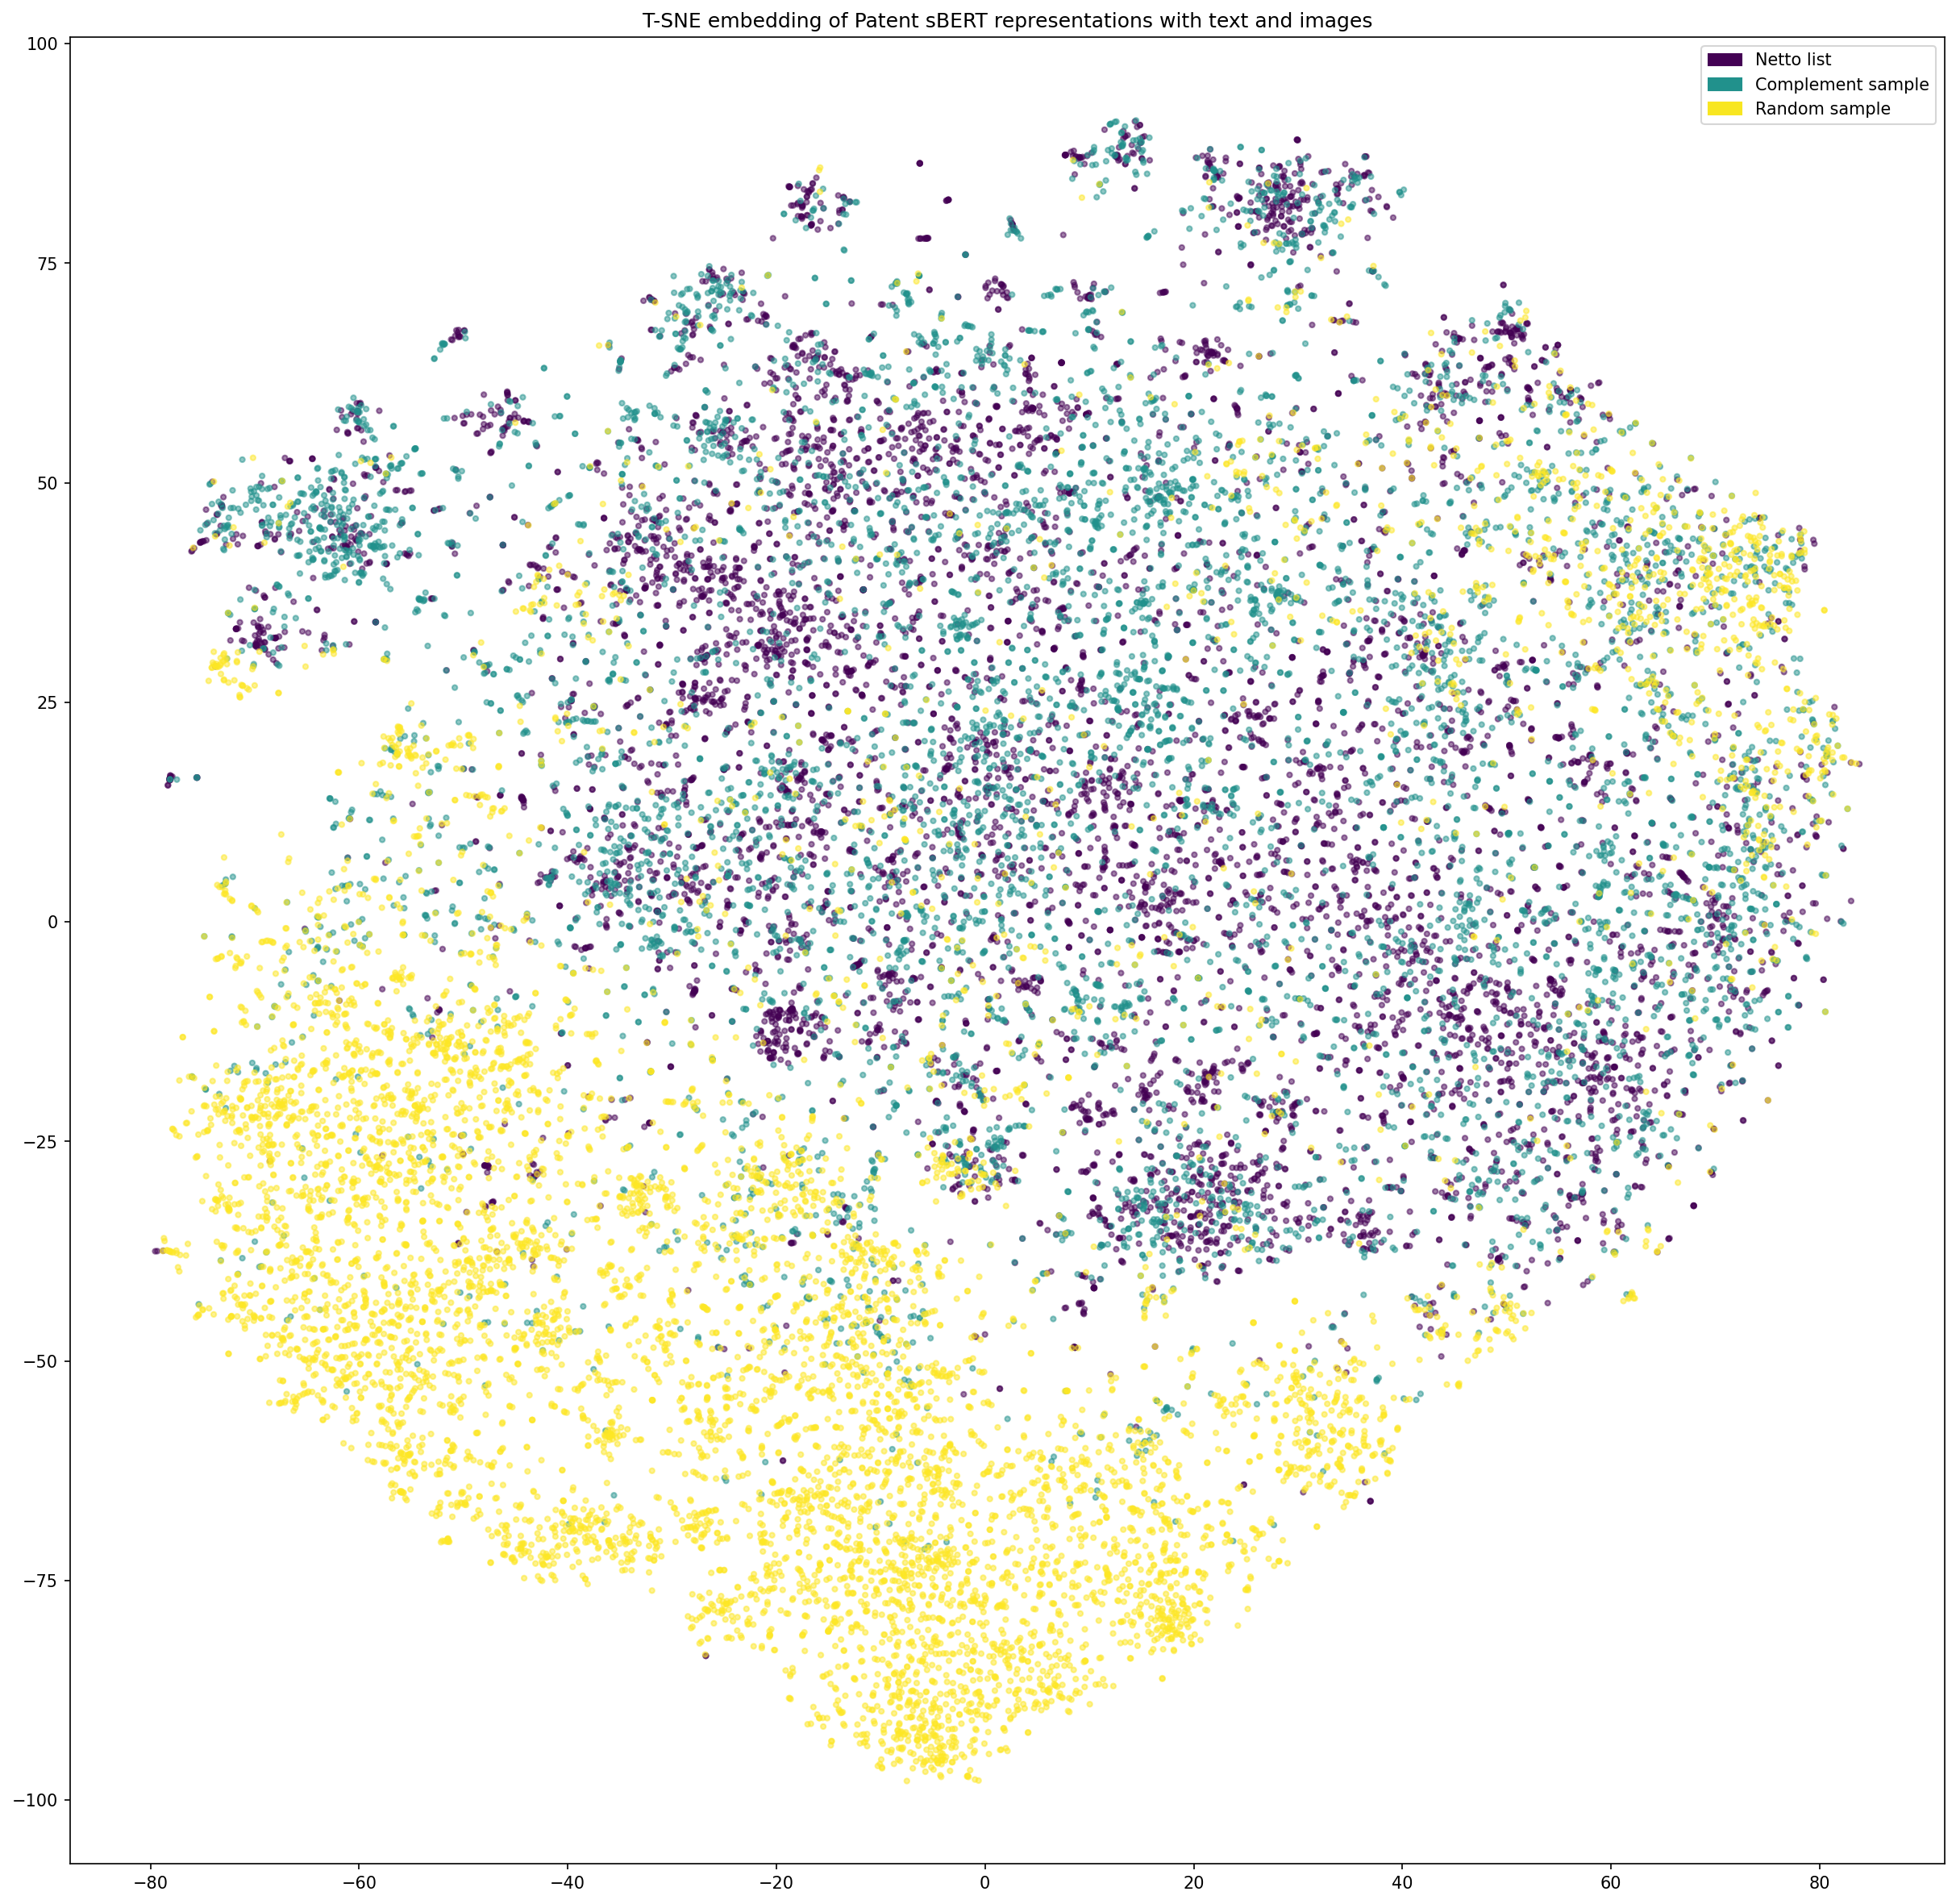

In [78]:
fig = plt.figure(figsize=(20,20), dpi=150)
col_y = patent_sbert_y / 2
mapped_col_y = cmap(col_y)
plt.scatter(patent_sbert_embedded_X[:,0], patent_sbert_embedded_X[:,1], c=mapped_col_y, alpha=.5, marker='.')
plt.legend(handles=colors)
plt.title("T-SNE embedding of Patent sBERT representations with text and images")

In [79]:
normed_X = patent_sbert_X/np.linalg.norm(patent_sbert_X, axis=-1, keepdims=True)

In [80]:
cos_normed_w_images_X = normed_w_images_X @ normed_w_images_X.T

In [ ]:
cos_normed_only_images_X = normed_only_images_X @ normed_only_images_X.T

In [ ]:
cos_normed_w_images_X = normed_w_images_X @ normed_w_images_X.T

We're not interested in the similarity to self, so we set the diagonal to -2 (-1 is the lowest cosine similiarity values). This ensures that we can remove these elments by removing the first column from the nearest neighbour matrix

In [81]:
np.fill_diagonal(cos_normed_w_images_X, -2)
cos_normed_w_images_X

array([[-2.        ,  0.5225096 ,  0.64301664, ...,  0.60834455,
         0.56024367,  0.6302009 ],
       [ 0.5225096 , -2.        ,  0.69872963, ...,  0.4172783 ,
         0.40358454,  0.50511634],
       [ 0.64301664,  0.69872963, -2.        , ...,  0.49799454,
         0.43898225,  0.56868523],
       ...,
       [ 0.60834455,  0.4172783 ,  0.49799454, ..., -2.        ,
         0.5642176 ,  0.5117853 ],
       [ 0.56024367,  0.40358454,  0.43898225, ...,  0.5642176 ,
        -2.        ,  0.4764248 ],
       [ 0.6302009 ,  0.50511634,  0.56868523, ...,  0.5117853 ,
         0.4764248 , -2.        ]], dtype=float32)

In [131]:
sorted_by_nearest_neighbours = np.argsort(cos_normed_w_images_X, axis=1)[:, 1:]  # We drop the first column, the node itself

In [110]:
np.argmax(cos_normed_w_images_X[0])

1238

In [111]:
cos_normed_w_images_X[0,1238]

0.9958919

In [132]:
nearest_neighbours_classes = clip_w_images_y[sorted_by_nearest_neighbours] 
nearest_neighbours_classes

array([[0, 2, 1, ..., 2, 2, 2],
       [0, 1, 2, ..., 2, 1, 2],
       [0, 2, 0, ..., 1, 1, 2],
       ...,
       [0, 2, 0, ..., 1, 1, 0],
       [0, 2, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 1, 1, 0]])

In [143]:
ks = np.arange(1, 100)
k_nearest_neighbours = dict()
for k in ks:
    subset = nearest_neighbours_classes[:,-k:]
    label_counts = []
    for l in labels:
        label_counts.append(np.sum(subset == l, axis=1))

    k_nearest_neighbours[k] = np.array(label_counts)


In [144]:
k_nearest_neighbours[1]

array([[0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [146]:
class_fractions = dict()
for k, label_counts in k_nearest_neighbours.items():
    k_fractions = label_counts / k
    class_fractions[k] = k_fractions


In [148]:
class_predictions = dict()
for k, fractions in class_fractions.items():
    class_prediction = np.argmax(fractions, axis=0)
    class_predictions[k] = class_prediction

In [153]:
class_predictions[5] == clip_w_images_y

array([ True,  True,  True, ..., False,  True, False])

In [ ]:
class_comparisons = [(0,1), (0,2)]
for pos, neg in class_comparisons:
    relevant_indices = y[y==pos or y == neg]

In [164]:
(cos_normed_w_images_X[(clip_w_images_y==0) | (clip_w_images_y==1)][:,(clip_w_images_y==0) | (clip_w_images_y==1)]).shape

(14617, 14617)

In [82]:
def knn_evaluation(normed_X, y, class_comparisons=((0,1), (0,2)), max_k=500):
    comp_perf = dict()

    for pos, neg in class_comparisons:
        comp_labels = np.array([pos, neg])
        comp_indx = (y==pos) | (y==neg)
        comp_y = y[comp_indx]
        comp_X = normed_X[comp_indx]
        cos_sim = comp_X @ comp_X.T
        np.fill_diagonal(cos_sim, -2)
        sorted_by_nearest_neighbours = np.argsort(cos_sim, axis=1)
        dropped_self = sorted_by_nearest_neighbours[:,1:]
        nearest_neighbours_classes = comp_y[dropped_self]
        
        k_nearest_neighbours = dict()
        for k in np.arange(1, max_k+1):
            subset = nearest_neighbours_classes[:,-k:]
            label_counts = []
            for l in (pos, neg):
                label_counts.append(np.sum(subset == l, axis=1))
            k_nearest_neighbours[k] = np.array(label_counts)

        class_fractions = dict()
        for k, label_counts in k_nearest_neighbours.items():
            k_fractions = label_counts / k
            class_fractions[k] = k_fractions        

        class_predictions = dict()
        for k, fractions in class_fractions.items():
            class_prediction = np.argmax(fractions, axis=0)  # Because of how we stack the arrays in k_nearest_neighbour, each example is along the column
            class_predictions[k] = comp_labels[class_prediction]

        pos_idx = comp_y == pos
        neg_idx = comp_y == neg
        
        k_perf = dict()
        for k, class_prediction in class_predictions.items():
            true_positives = np.sum(class_prediction[pos_idx] == pos)
            true_negatives = np.sum(class_prediction[neg_idx] == neg)
            false_positives = np.sum(class_prediction[pos_idx] == neg)
            false_negatives = np.sum(class_prediction[neg_idx] == pos)
            k_perf[k] = dict(true_positives=true_positives, true_negatives=true_negatives, false_positives=false_positives, false_negatives=false_negatives)

        comp_perf[(pos, neg)] = k_perf
        
    return comp_perf


    
    

In [83]:
cp = knn_evaluation(normed_X, patent_sbert_y)

In [84]:
recall_perf = {perf_pair: {k: perf['true_positives']/(perf['false_negatives']+perf['true_positives']) for k, perf in k_perf.items()} for perf_pair, k_perf in cp.items()}

In [85]:
precision_perf = {perf_pair: {k: perf['true_positives']/(perf['false_positives']+perf['true_positives']) for k, perf in k_perf.items()} for perf_pair, k_perf in cp.items()}

In [41]:
precision_perf

{(0, 1): {1: 0.8049193128578865,
  2: 0.920223841749089,
  3: 0.8146798542425819,
  4: 0.898750650702759,
  5: 0.8295158771473191,
  6: 0.8912024986985945,
  7: 0.8358927641853201,
  8: 0.8883394065590838,
  9: 0.8439614783966684,
  10: 0.885736595523165,
  11: 0.8492972410203019,
  12: 0.8850858927641854,
  13: 0.8517699115044248,
  14: 0.8867777199375325,
  15: 0.8559344091618949,
  16: 0.885736595523165,
  17: 0.8603591879229568,
  18: 0.8844351900052057,
  19: 0.8614003123373243,
  20: 0.8867777199375325,
  21: 0.8647839666840187,
  22: 0.8863872982821447,
  23: 0.8675169182717335,
  24: 0.8901613742842269,
  25: 0.8701197293076522,
  26: 0.8885996876626757,
  27: 0.8737636647579385,
  28: 0.8906819364914107,
  29: 0.8761061946902655,
  30: 0.8939354502863092,
  31: 0.8766267568974493,
  32: 0.892243623112962,
  33: 0.8797501301405518,
  34: 0.8921134825611661,
  35: 0.8802706923477356,
  36: 0.894325871941697,
  37: 0.8818323789692868,
  38: 0.8957574180114524,
  39: 0.88391462779

In [86]:
cmap = plt.get_cmap('plasma')

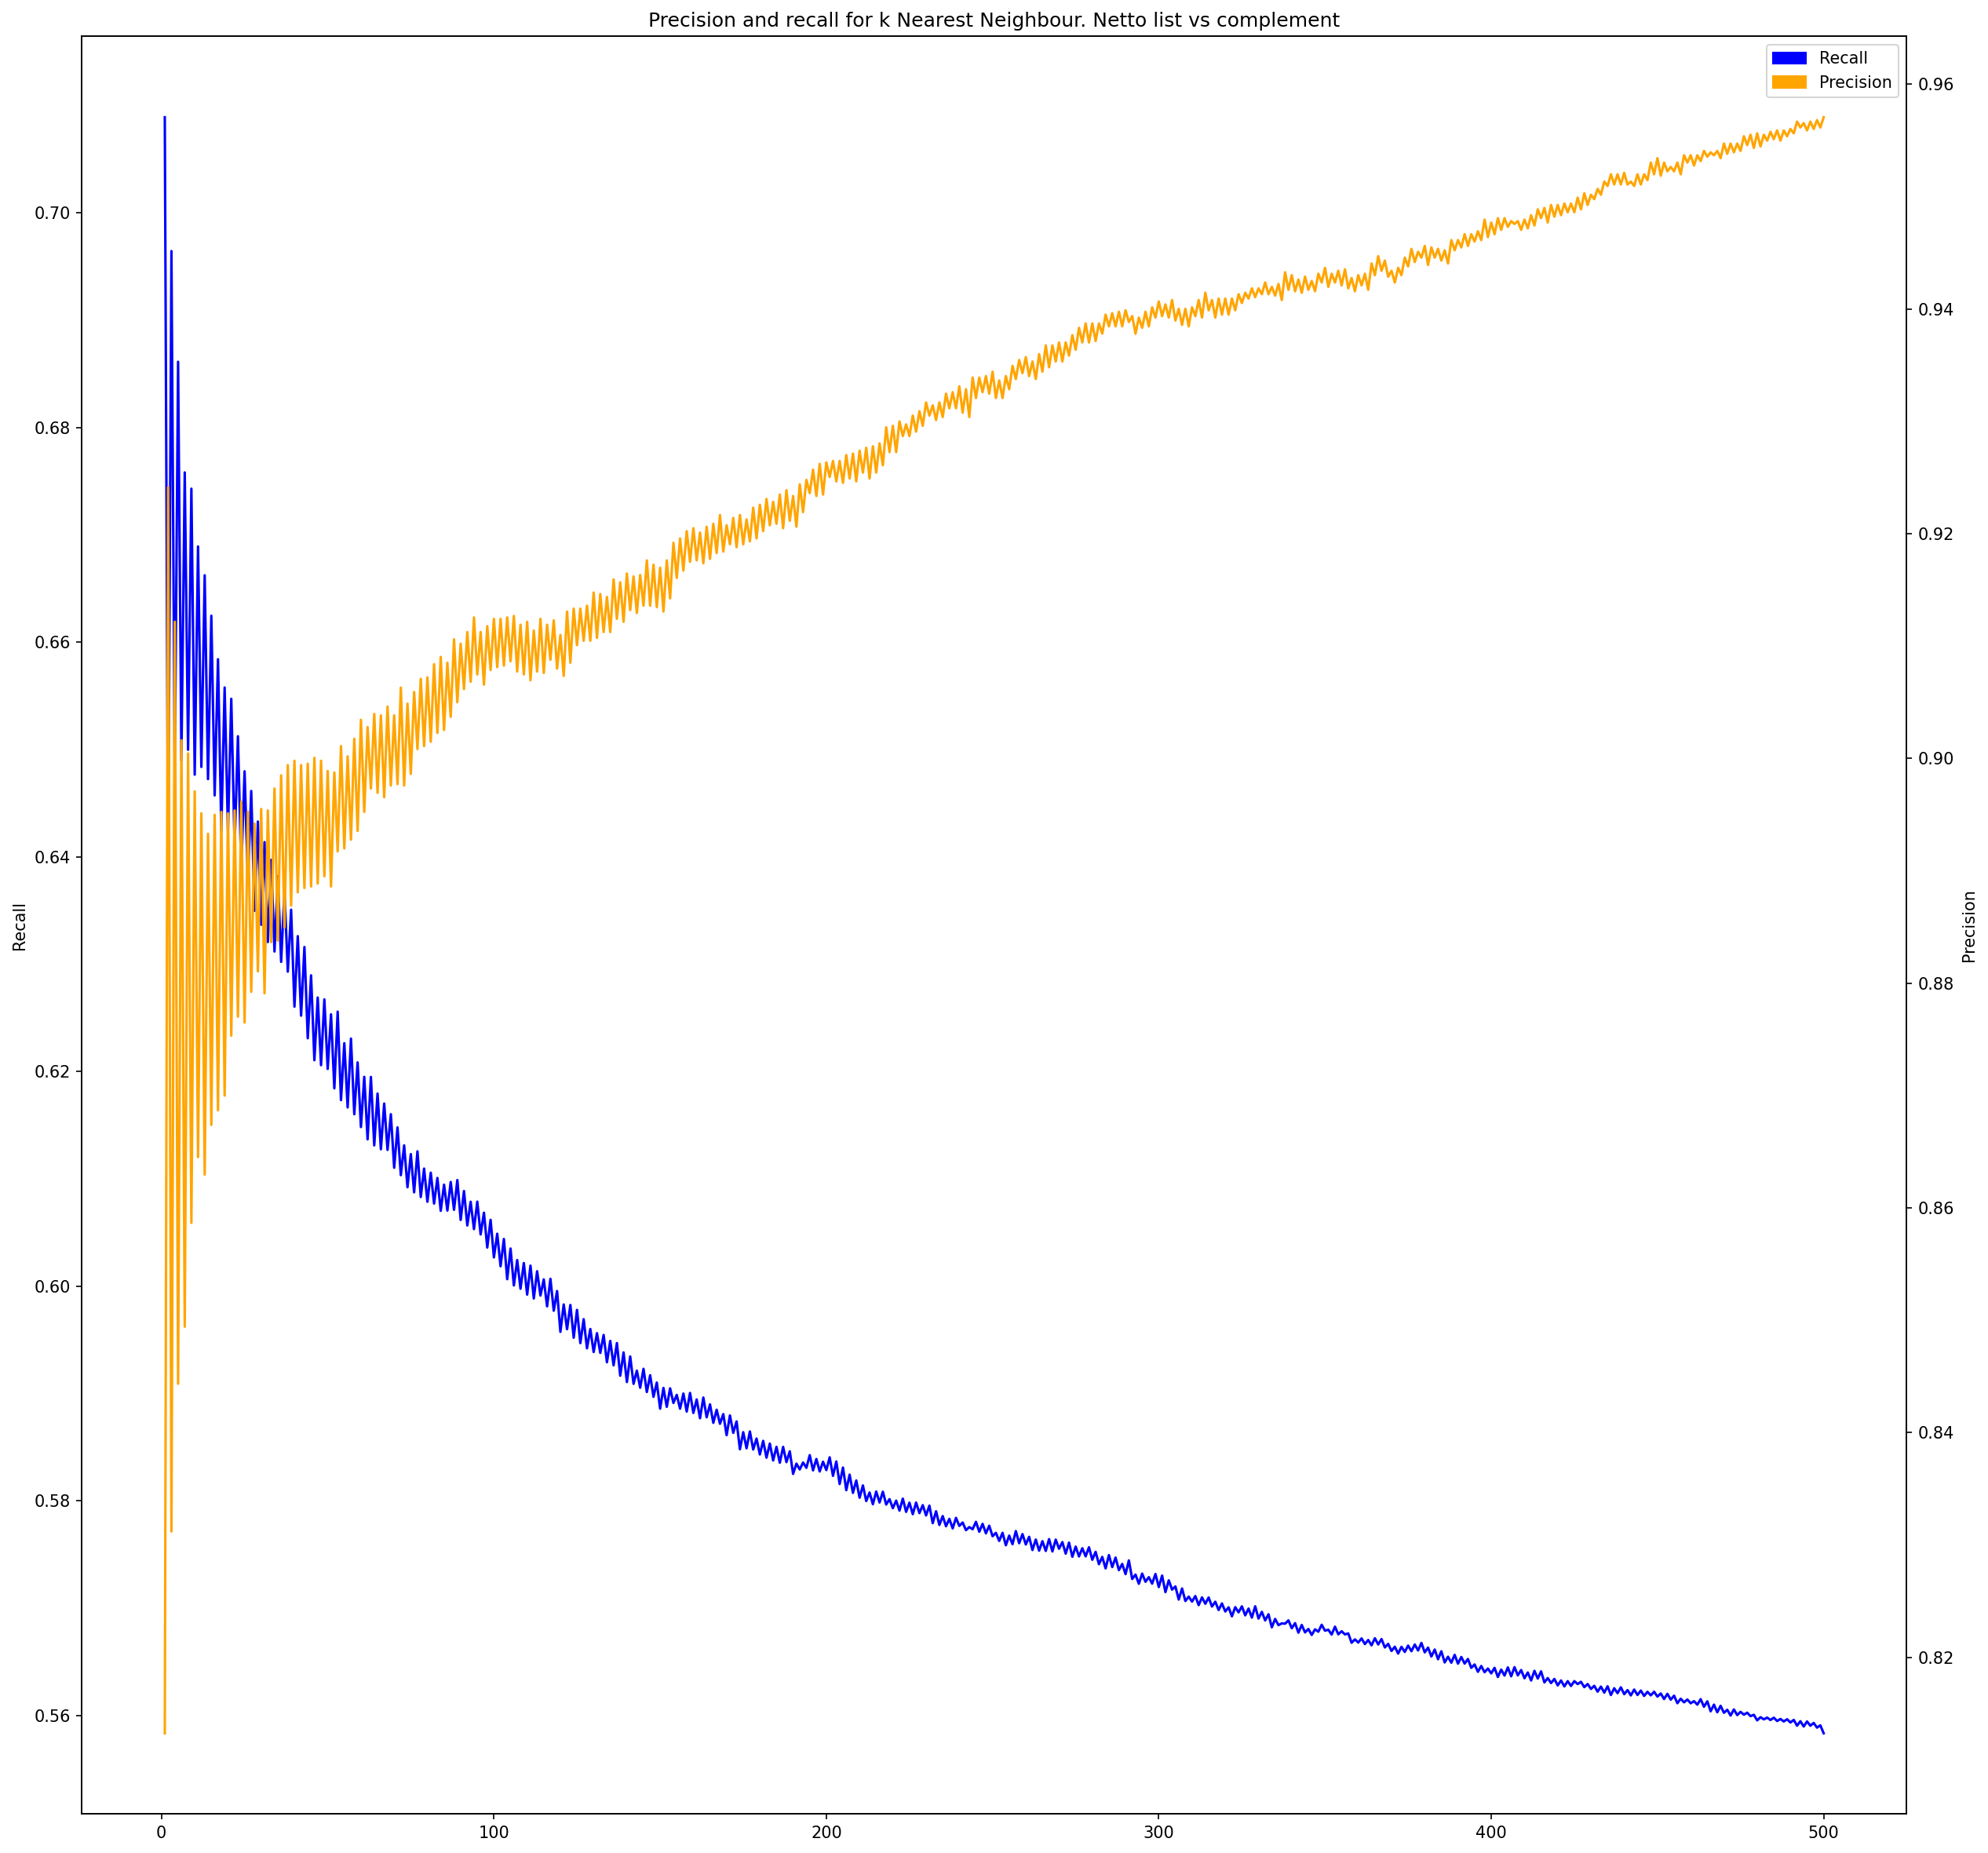

In [87]:
netto_compl_recall = recall_perf[(0,1)]
netto_compl_precision = precision_perf[(0,1)]

figure = plt.figure(figsize=(20,20), dpi=150)
recall_x, recalls = zip(*sorted(netto_compl_recall.items()))
precision_x, precisions = zip(*sorted(netto_compl_precision.items()))

ax = plt.gca()
ax.plot(recall_x, recalls, c='blue', label="Recall")
ax.set_ylabel('Recall')
ax2 = ax.twinx()
ax2.plot(precision_x, precisions, c='orange', label="Precision")
ax2.set_ylabel('Precision')
handles = [mpatches.Patch(color='blue', label='Recall'), 
            mpatches.Patch(color='orange', label='Precision')]
plt.title("Precision and recall for k Nearest Neighbour. Netto list vs complement")
plt.legend(handles=handles)

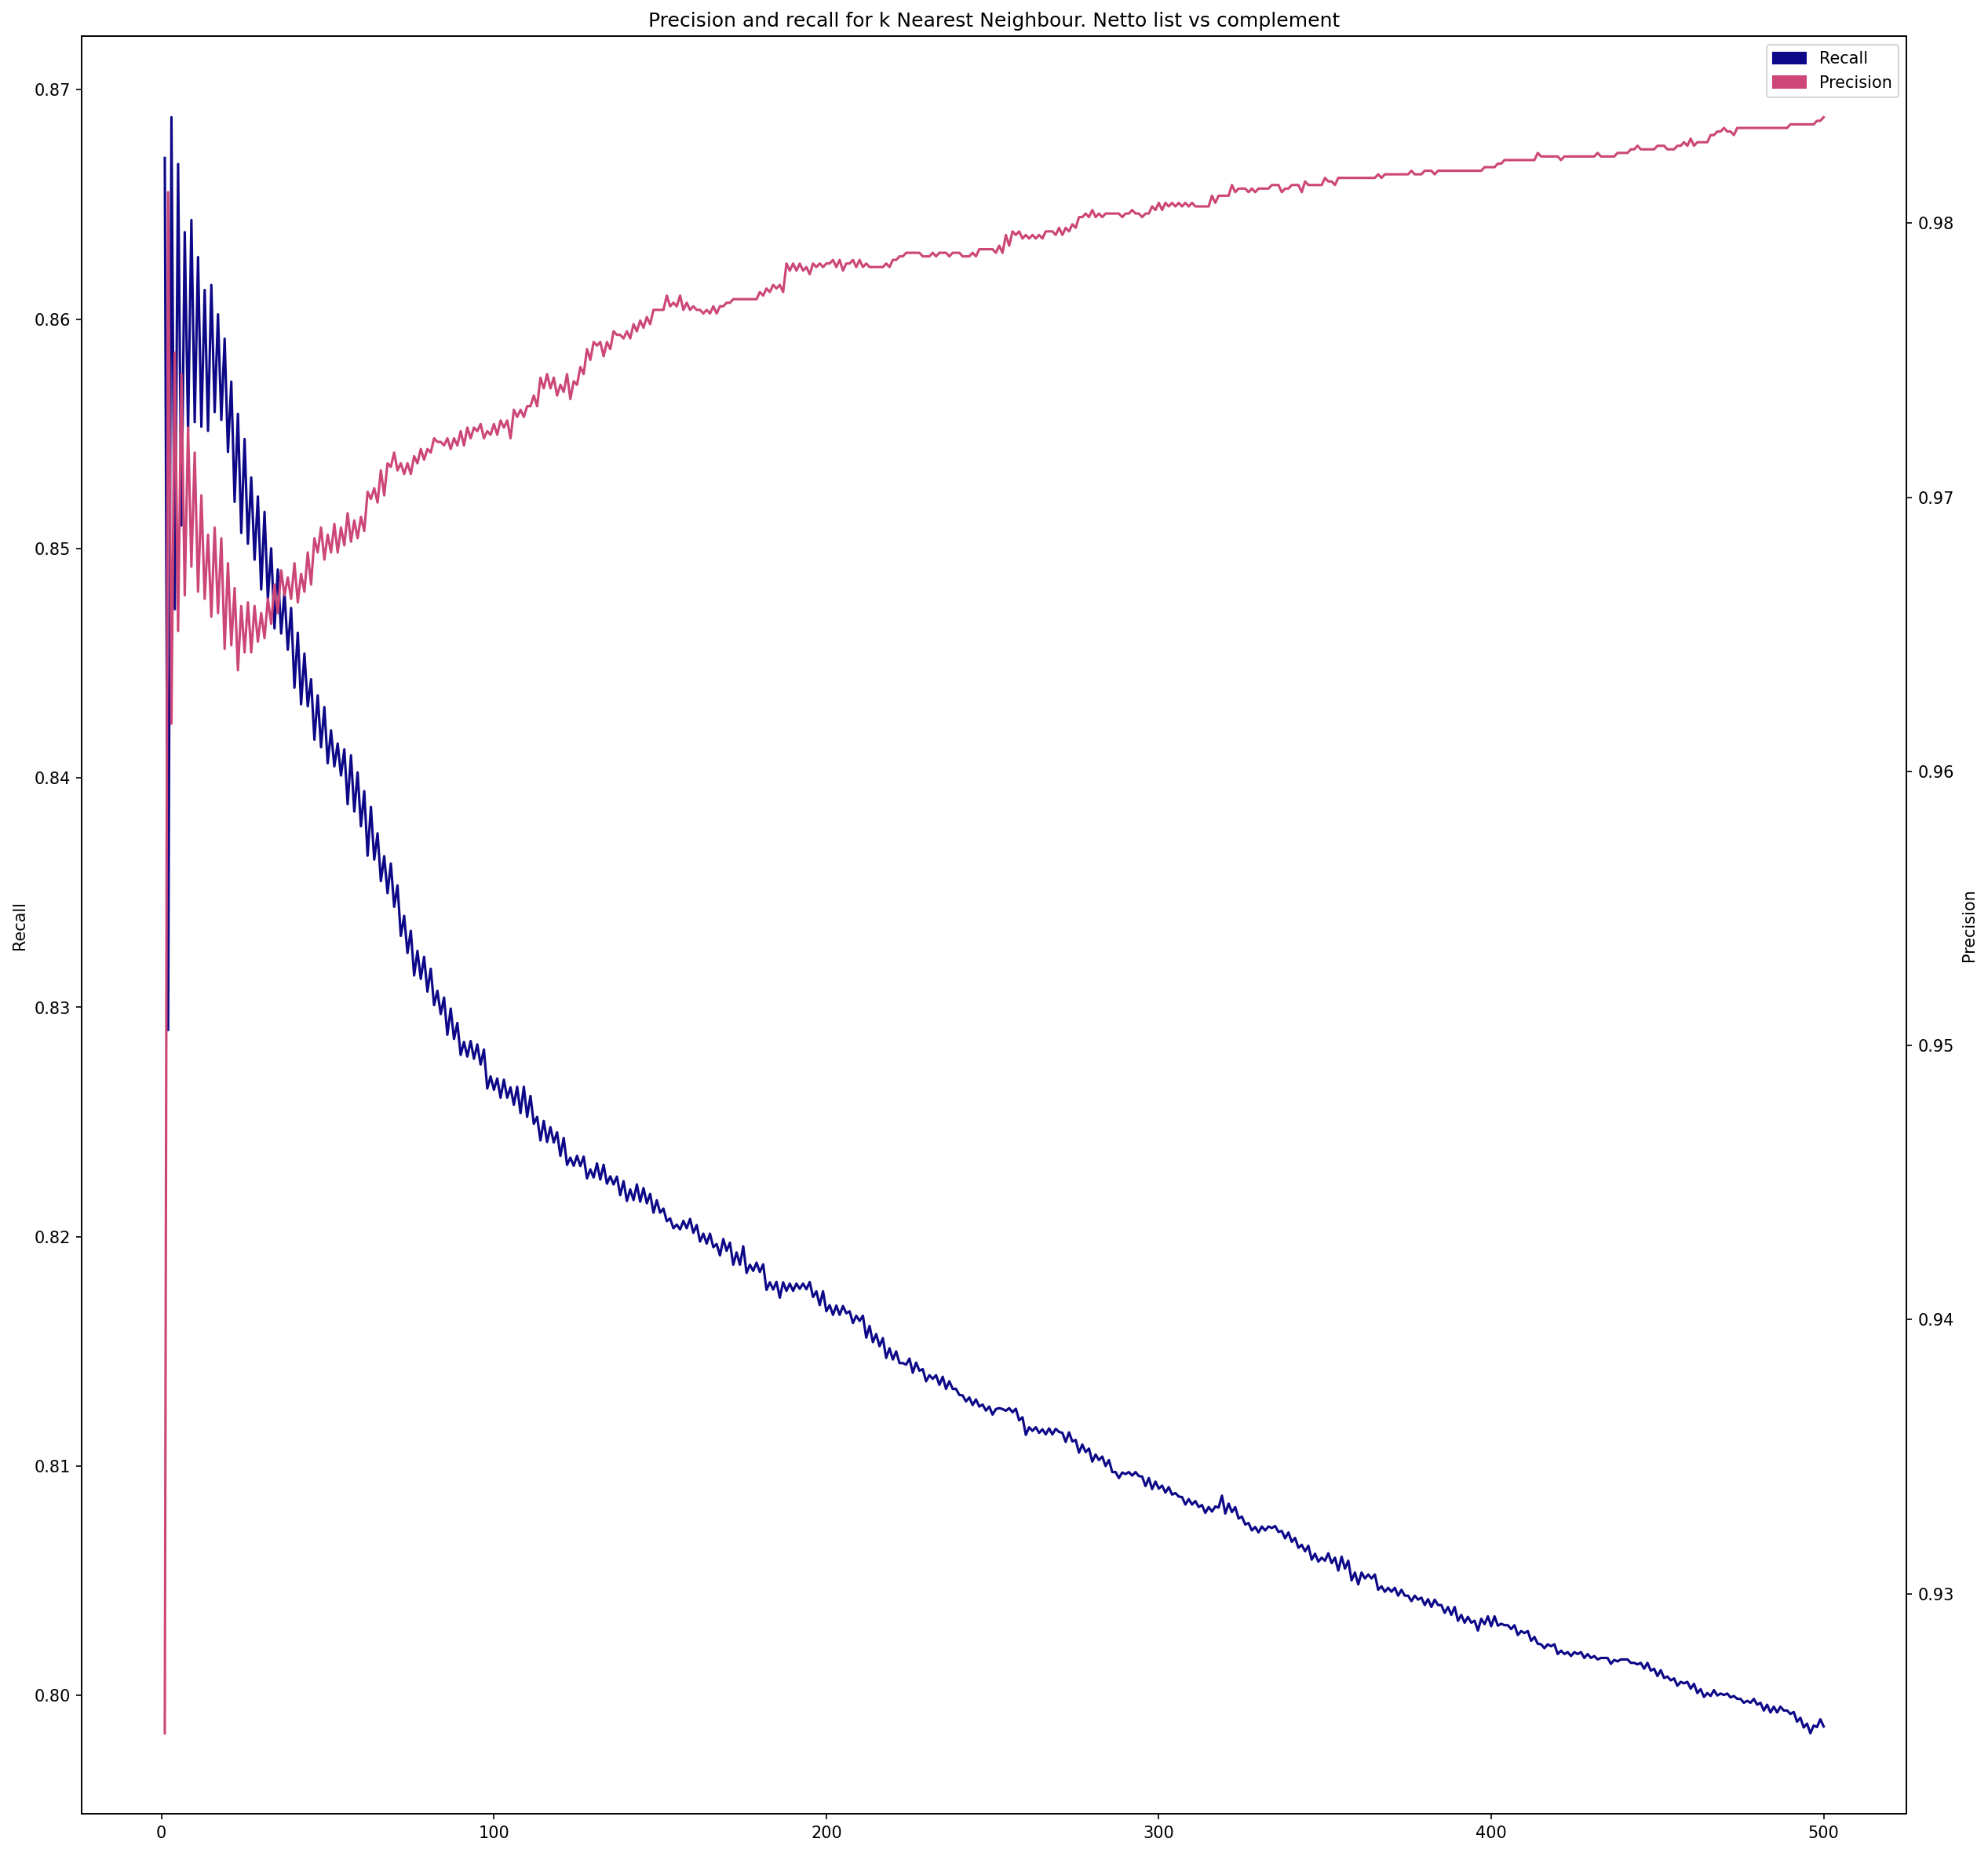

In [58]:
netto_random_recall = recall_perf[(0,2)]
netto_random_precision = precision_perf[(0,2)]

figure = plt.figure(figsize=(20,20), dpi=150)
recall_x, recalls = zip(*sorted(netto_random_recall.items()))
precision_x, precisions = zip(*sorted(netto_random_precision.items()))
ax = plt.gca()
ax.plot(recall_x, recalls, c=cmap(0), label="Recall")
ax.set_ylabel('Recall')
ax2 = ax.twinx()
ax2.plot(precision_x, precisions, c=cmap(.5), label="Precision")
ax2.set_ylabel('Precision')
handles = [mpatches.Patch(color=cmap(0), label='Recall'), 
            mpatches.Patch(color=cmap(0.5), label='Precision')]
plt.title("Precision and recall for k Nearest Neighbour. Netto list vs complement")
plt.legend(handles=handles)